Installation of required libraries and basic setup

In [ ]:
import pandas as pd
import numpy as np
import h5py
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/data')

Testing the dataset

In [ ]:
path_single = r'TrainData/img/image_2000.h5'
path_single_mask = r'TrainData/mask/mask_2000.h5'

ls ['img']
input data shape: (128, 128, 14)
data ndvi shape  (128, 128) f_data shape:  (1, 128, 128, 3)


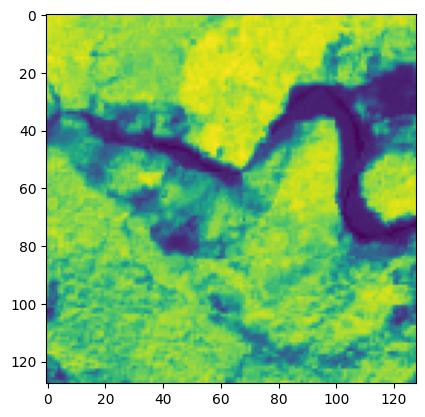

In [ ]:
f_data = np.zeros((1, 128,128, 3))
with h5py.File(path_single) as hdf:
    ls = list(hdf.keys())
    print("ls", ls)
    data = np.array(hdf.get('img'))
    print("input data shape:", data.shape)
    plt.imshow(data[:, :, 3:0:-1])

    data_red = data[:, :, 3]
    data_green = data[:, :, 2]
    data_blue = data[:, :, 1]
    data_nir = data[:, :, 7]
    data_rgb = data[:, :, 3:0:-1]
    data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
    f_data[0, :, :, 0] =data_ndvi
    f_data[0, :, :, 1] = data[:, :, 12]
    f_data[0, :, :, 2] = data[:, :, 13]

    print("data ndvi shape ", data_ndvi.shape, "f_data shape: ", f_data.shape)
    plt.imshow(data_ndvi)

ls ['mask']
input data shape: (128, 128)


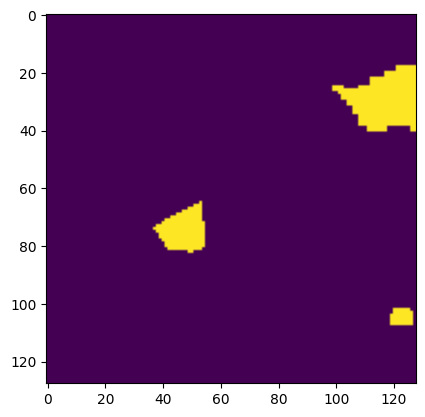

In [ ]:
with h5py.File(path_single_mask) as hdf:
    ls = list(hdf.keys())
    print("ls", ls)
    data = np.array(hdf.get('mask'))
    print("input data shape:", data.shape)
    plt.imshow(data)

Using all dataset

In [ ]:
path_single = r"TrainData/img/image_10.h5"
path_single_mask = r'TrainData/mask/mask_1.h5'
TRAIN_PATH = r"TrainData/img/*.h5"
TRAIN_MASK = r'TrainData/mask/*.h5'

TRAIN_XX = np.zeros((3799, 128, 128, 6))
TRAIN_YY = np.zeros((3799, 128, 128, 1))
all_train = sorted(glob.glob(TRAIN_PATH))
all_mask = sorted(glob.glob(TRAIN_MASK))

Train with RGB, NDVI, DEM, and Slope

In [ ]:
#testing for google colab GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
for i, (img, mask) in enumerate(zip(all_train, all_mask)):
    print(i, img, mask)
    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('img'))

        # assign 0 for the nan value
        data[np.isnan(data)] = 0.000001

        # to normalize the data
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # ndvi calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))

        # final array
        TRAIN_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  #RED
        TRAIN_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
        TRAIN_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
        TRAIN_XX[i, :, :, 3] = data_ndvi #NDVI
        TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope #SLOPE
        TRAIN_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION


    with h5py.File(mask) as hdf:
        ls = list(hdf.keys())
        data=np.array(hdf.get('mask'))
        TRAIN_YY[i, :, :, 0] = data



Testing min, max values in train data

In [ ]:
# TRAIN_XX_n = TRAIN_XX / TRAIN_XX.max()
TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001
print(TRAIN_XX.min(), TRAIN_XX.max(), TRAIN_YY.min(), TRAIN_YY.max())

-1.0 1.0 0.0 1.0


Custom loss function (Dice Loss)

In [ ]:
def dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator / denominator

Visualization of the training data

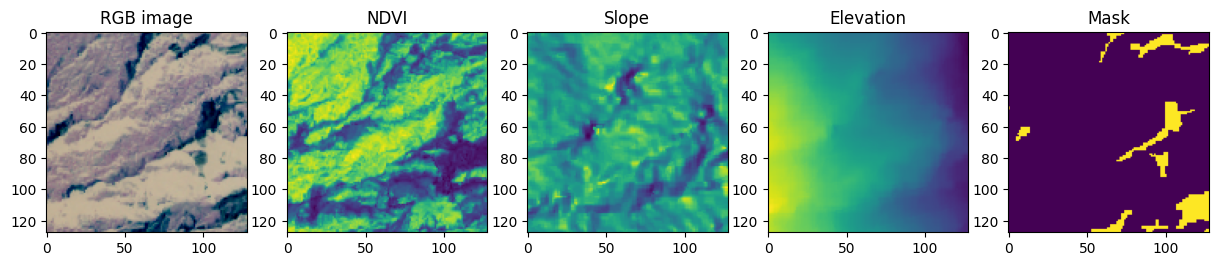

In [ ]:
img=234
fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(15,10))


ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask")
ax1.imshow(TRAIN_XX[img, :, :, 0:3])
ax2.imshow(TRAIN_XX[img, :, :, 3])
ax3.imshow(TRAIN_XX[img, :, :, 4])
ax4.imshow(TRAIN_XX[img, :, :, 5])
ax5.imshow(TRAIN_YY[img, :, :, 0])

Validation split

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(TRAIN_XX, TRAIN_YY, test_size=0.2, shuffle= True)

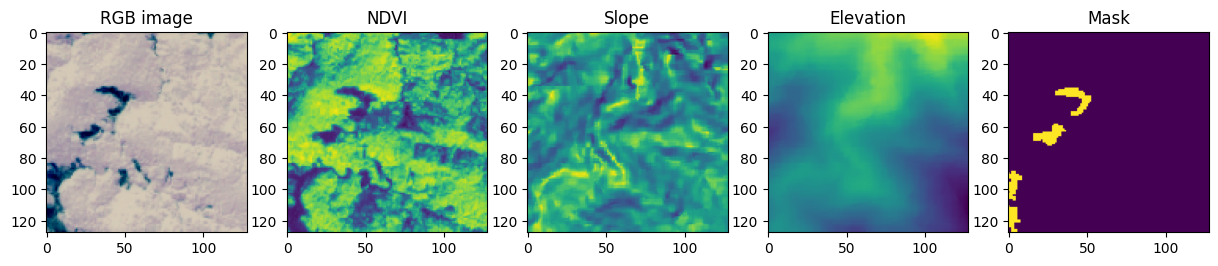

In [ ]:
img=1545
fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(15,10))

ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask")
ax1.imshow(x_train[img, :, :, 0:3])
ax2.imshow(x_train[img, :, :, 3])
ax3.imshow(x_train[img, :, :, 4])
ax4.imshow(x_train[img, :, :, 5])
ax5.imshow(y_train[img, :, :, 0])

In [ ]:
x_train.shape, y_train.shape

((3039, 128, 128, 6), (3039, 128, 128, 1))

In [ ]:
# to release some memory, delete the unnecessary variable
del TRAIN_XX
del TRAIN_YY
del all_train
del all_mask

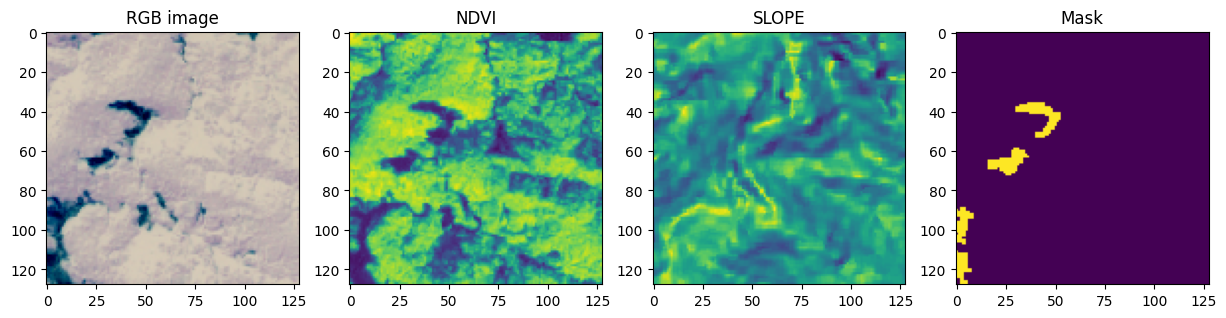

In [ ]:
img=1545
fig,(ax1,ax2, ax3, ax4)= plt.subplots(1,4,figsize=(15,10))


ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("SLOPE")
ax4.set_title("Mask")
ax1.imshow(x_train[img, :, :, 0:3])
ax2.imshow(x_train[img, :, :, 3])
ax3.imshow(x_train[img, :, :, 4])
ax4.imshow(y_train[img, :, :, 0])

Unet Model

In [ ]:
import sys
import os

# Define the absolute path to the directory containing utils.py
# Adjust 'Colab Notebooks' if your notebook is directly in MyDrive
UTILS_DIR = '/content/drive/MyDrive/Colab Notebooks'

# Add the directory to the system path
if UTILS_DIR not in sys.path:
    sys.path.append(UTILS_DIR)

print("sys.path:", sys.path) # Print the system path for debugging

from utils import recall_m, precision_m, f1_m
def unet_model(IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS):
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS))

    # Converted inputs to floating
    #s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)


    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    #Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

    return model

sys.path: ['/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Colab Notebooks']


In [ ]:
model = unet_model(128, 128, 6)
# model.summary()
checkpointer = tf.keras.callbacks.ModelCheckpoint("best_model.h5", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max")
# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_m', patience=10, verbose=1, mode='max')

callbacks = [
    # earlyStopping,
    checkpointer
    ]
history = model.fit(x_train, y_train, batch_size=16,
          epochs=100,
          verbose = 2,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks)

model.save("model_save.h5")

Epoch 1/100

Epoch 1: val_f1_m improved from -inf to 0.49290, saving model to best_model.h5


190/190 - 60s - 317ms/step - accuracy: 0.9707 - f1_m: 0.0774 - loss: 0.0908 - precision_m: 0.3532 - recall_m: 0.0621 - val_accuracy: 0.9817 - val_f1_m: 0.4929 - val_loss: 0.0487 - val_precision_m: 0.6957 - val_recall_m: 0.4038
Epoch 2/100

Epoch 2: val_f1_m improved from 0.49290 to 0.61092, saving model to best_model.h5


190/190 - 9s - 47ms/step - accuracy: 0.9826 - f1_m: 0.5352 - loss: 0.0460 - precision_m: 0.6932 - recall_m: 0.4730 - val_accuracy: 0.9844 - val_f1_m: 0.6109 - val_loss: 0.0413 - val_precision_m: 0.6980 - val_recall_m: 0.5598
Epoch 3/100

Epoch 3: val_f1_m improved from 0.61092 to 0.64512, saving model to best_model.h5


190/190 - 8s - 44ms/step - accuracy: 0.9842 - f1_m: 0.5711 - loss: 0.0419 - precision_m: 0.7260 - recall_m: 0.4997 - val_accuracy: 0.9850 - val_f1_m: 0.6451 - val_loss: 0.0439 - val_precision_m: 0.6802 - val_recall_m: 0.6284
Epoch 4/100

Epoch 4: val_f1_m did not improve from 0.64512
190/190 - 8s - 42ms/step - accuracy: 0.9854 - f1_m: 0.6122 - loss: 0.0386 - precision_m: 0.7474 - recall_m: 0.5350 - val_accuracy: 0.9847 - val_f1_m: 0.6330 - val_loss: 0.0431 - val_precision_m: 0.6694 - val_recall_m: 0.6098
Epoch 5/100

Epoch 5: val_f1_m improved from 0.64512 to 0.66396, saving model to best_model.h5


190/190 - 9s - 46ms/step - accuracy: 0.9859 - f1_m: 0.6307 - loss: 0.0371 - precision_m: 0.7633 - recall_m: 0.5517 - val_accuracy: 0.9870 - val_f1_m: 0.6640 - val_loss: 0.0338 - val_precision_m: 0.7657 - val_recall_m: 0.5949
Epoch 6/100

Epoch 6: val_f1_m did not improve from 0.66396
190/190 - 8s - 41ms/step - accuracy: 0.9859 - f1_m: 0.6212 - loss: 0.0365 - precision_m: 0.7623 - recall_m: 0.5453 - val_accuracy: 0.9862 - val_f1_m: 0.6534 - val_loss: 0.0356 - val_precision_m: 0.7362 - val_recall_m: 0.5991
Epoch 7/100

Epoch 7: val_f1_m improved from 0.66396 to 0.67009, saving model to best_model.h5


190/190 - 9s - 48ms/step - accuracy: 0.9865 - f1_m: 0.6387 - loss: 0.0351 - precision_m: 0.7627 - recall_m: 0.5639 - val_accuracy: 0.9872 - val_f1_m: 0.6701 - val_loss: 0.0332 - val_precision_m: 0.7663 - val_recall_m: 0.6048
Epoch 8/100

Epoch 8: val_f1_m improved from 0.67009 to 0.69068, saving model to best_model.h5


190/190 - 8s - 42ms/step - accuracy: 0.9867 - f1_m: 0.6501 - loss: 0.0344 - precision_m: 0.7806 - recall_m: 0.5709 - val_accuracy: 0.9876 - val_f1_m: 0.6907 - val_loss: 0.0330 - val_precision_m: 0.7606 - val_recall_m: 0.6396
Epoch 9/100

Epoch 9: val_f1_m did not improve from 0.69068
190/190 - 8s - 42ms/step - accuracy: 0.9870 - f1_m: 0.6551 - loss: 0.0335 - precision_m: 0.7735 - recall_m: 0.5807 - val_accuracy: 0.9876 - val_f1_m: 0.6820 - val_loss: 0.0325 - val_precision_m: 0.7828 - val_recall_m: 0.6119
Epoch 10/100

Epoch 10: val_f1_m did not improve from 0.69068
190/190 - 8s - 43ms/step - accuracy: 0.9869 - f1_m: 0.6605 - loss: 0.0333 - precision_m: 0.7825 - recall_m: 0.5849 - val_accuracy: 0.9875 - val_f1_m: 0.6686 - val_loss: 0.0316 - val_precision_m: 0.8013 - val_recall_m: 0.5812
Epoch 11/100

Epoch 11: val_f1_m did not improve from 0.69068
190/190 - 10s - 52ms/step - accuracy: 0.9869 - f1_m: 0.6568 - loss: 0.0335 - precision_m: 0.7796 - recall_m: 0.5805 - val_accuracy: 0.9878 - 

190/190 - 9s - 49ms/step - accuracy: 0.9872 - f1_m: 0.6592 - loss: 0.0326 - precision_m: 0.7844 - recall_m: 0.5822 - val_accuracy: 0.9877 - val_f1_m: 0.6913 - val_loss: 0.0311 - val_precision_m: 0.7684 - val_recall_m: 0.6361
Epoch 13/100

Epoch 13: val_f1_m improved from 0.69132 to 0.70599, saving model to best_model.h5


190/190 - 8s - 43ms/step - accuracy: 0.9871 - f1_m: 0.6577 - loss: 0.0329 - precision_m: 0.7786 - recall_m: 0.5859 - val_accuracy: 0.9880 - val_f1_m: 0.7060 - val_loss: 0.0307 - val_precision_m: 0.7606 - val_recall_m: 0.6654
Epoch 14/100

Epoch 14: val_f1_m did not improve from 0.70599
190/190 - 8s - 41ms/step - accuracy: 0.9873 - f1_m: 0.6639 - loss: 0.0323 - precision_m: 0.7863 - recall_m: 0.5890 - val_accuracy: 0.9878 - val_f1_m: 0.6804 - val_loss: 0.0307 - val_precision_m: 0.7974 - val_recall_m: 0.6014
Epoch 15/100

Epoch 15: val_f1_m did not improve from 0.70599
190/190 - 8s - 42ms/step - accuracy: 0.9876 - f1_m: 0.6770 - loss: 0.0314 - precision_m: 0.7872 - recall_m: 0.6042 - val_accuracy: 0.9882 - val_f1_m: 0.6942 - val_loss: 0.0297 - val_precision_m: 0.7935 - val_recall_m: 0.6231
Epoch 16/100

Epoch 16: val_f1_m improved from 0.70599 to 0.71248, saving model to best_model.h5


190/190 - 9s - 49ms/step - accuracy: 0.9879 - f1_m: 0.6808 - loss: 0.0305 - precision_m: 0.7827 - recall_m: 0.6119 - val_accuracy: 0.9882 - val_f1_m: 0.7125 - val_loss: 0.0302 - val_precision_m: 0.7503 - val_recall_m: 0.6851
Epoch 17/100

Epoch 17: val_f1_m did not improve from 0.71248
190/190 - 8s - 41ms/step - accuracy: 0.9878 - f1_m: 0.6832 - loss: 0.0309 - precision_m: 0.7899 - recall_m: 0.6128 - val_accuracy: 0.9881 - val_f1_m: 0.7012 - val_loss: 0.0305 - val_precision_m: 0.7639 - val_recall_m: 0.6551
Epoch 18/100

Epoch 18: val_f1_m did not improve from 0.71248
190/190 - 8s - 42ms/step - accuracy: 0.9875 - f1_m: 0.6661 - loss: 0.0316 - precision_m: 0.7927 - recall_m: 0.5908 - val_accuracy: 0.9880 - val_f1_m: 0.6960 - val_loss: 0.0307 - val_precision_m: 0.7747 - val_recall_m: 0.6391
Epoch 19/100

Epoch 19: val_f1_m did not improve from 0.71248
190/190 - 8s - 41ms/step - accuracy: 0.9878 - f1_m: 0.6815 - loss: 0.0309 - precision_m: 0.7875 - recall_m: 0.6115 - val_accuracy: 0.9883 -

190/190 - 9s - 48ms/step - accuracy: 0.9882 - f1_m: 0.6923 - loss: 0.0295 - precision_m: 0.7910 - recall_m: 0.6250 - val_accuracy: 0.9883 - val_f1_m: 0.7132 - val_loss: 0.0296 - val_precision_m: 0.7570 - val_recall_m: 0.6807
Epoch 22/100

Epoch 22: val_f1_m did not improve from 0.71316
190/190 - 8s - 41ms/step - accuracy: 0.9883 - f1_m: 0.7001 - loss: 0.0291 - precision_m: 0.7959 - recall_m: 0.6339 - val_accuracy: 0.9868 - val_f1_m: 0.6282 - val_loss: 0.0341 - val_precision_m: 0.8458 - val_recall_m: 0.5075
Epoch 23/100

Epoch 23: val_f1_m did not improve from 0.71316
190/190 - 8s - 42ms/step - accuracy: 0.9879 - f1_m: 0.6843 - loss: 0.0305 - precision_m: 0.7924 - recall_m: 0.6151 - val_accuracy: 0.9882 - val_f1_m: 0.6825 - val_loss: 0.0303 - val_precision_m: 0.8159 - val_recall_m: 0.5935
Epoch 24/100

Epoch 24: val_f1_m did not improve from 0.71316
190/190 - 8s - 42ms/step - accuracy: 0.9885 - f1_m: 0.7029 - loss: 0.0286 - precision_m: 0.7958 - recall_m: 0.6377 - val_accuracy: 0.9882 -

190/190 - 9s - 49ms/step - accuracy: 0.9890 - f1_m: 0.7148 - loss: 0.0273 - precision_m: 0.8009 - recall_m: 0.6546 - val_accuracy: 0.9885 - val_f1_m: 0.7194 - val_loss: 0.0290 - val_precision_m: 0.7578 - val_recall_m: 0.6905
Epoch 30/100

Epoch 30: val_f1_m did not improve from 0.71938
190/190 - 8s - 41ms/step - accuracy: 0.9892 - f1_m: 0.7208 - loss: 0.0267 - precision_m: 0.8027 - recall_m: 0.6606 - val_accuracy: 0.9883 - val_f1_m: 0.7061 - val_loss: 0.0298 - val_precision_m: 0.7793 - val_recall_m: 0.6515
Epoch 31/100

Epoch 31: val_f1_m did not improve from 0.71938
190/190 - 8s - 42ms/step - accuracy: 0.9891 - f1_m: 0.7185 - loss: 0.0269 - precision_m: 0.8011 - recall_m: 0.6586 - val_accuracy: 0.9884 - val_f1_m: 0.7044 - val_loss: 0.0298 - val_precision_m: 0.7843 - val_recall_m: 0.6464
Epoch 32/100

Epoch 32: val_f1_m did not improve from 0.71938
190/190 - 8s - 42ms/step - accuracy: 0.9893 - f1_m: 0.7317 - loss: 0.0263 - precision_m: 0.8094 - recall_m: 0.6735 - val_accuracy: 0.9883 -

190/190 - 9s - 47ms/step - accuracy: 0.9894 - f1_m: 0.7314 - loss: 0.0261 - precision_m: 0.8111 - recall_m: 0.6726 - val_accuracy: 0.9885 - val_f1_m: 0.7203 - val_loss: 0.0296 - val_precision_m: 0.7547 - val_recall_m: 0.6954
Epoch 37/100

Epoch 37: val_f1_m did not improve from 0.72026
190/190 - 8s - 41ms/step - accuracy: 0.9897 - f1_m: 0.7383 - loss: 0.0253 - precision_m: 0.8114 - recall_m: 0.6839 - val_accuracy: 0.9882 - val_f1_m: 0.7133 - val_loss: 0.0306 - val_precision_m: 0.7536 - val_recall_m: 0.6845
Epoch 38/100

Epoch 38: val_f1_m did not improve from 0.72026
190/190 - 8s - 41ms/step - accuracy: 0.9895 - f1_m: 0.7342 - loss: 0.0257 - precision_m: 0.8137 - recall_m: 0.6753 - val_accuracy: 0.9881 - val_f1_m: 0.6847 - val_loss: 0.0310 - val_precision_m: 0.8160 - val_recall_m: 0.5965
Epoch 39/100

Epoch 39: val_f1_m did not improve from 0.72026
190/190 - 8s - 41ms/step - accuracy: 0.9899 - f1_m: 0.7479 - loss: 0.0247 - precision_m: 0.8156 - recall_m: 0.6949 - val_accuracy: 0.9884 -

In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(x_valid, y_valid, verbose=0)
print(loss, accuracy, f1_score, precision, recall)

0.043358832597732544 0.987765371799469 0.6793246269226074 0.8422493934631348 0.5723761916160583


Prediction

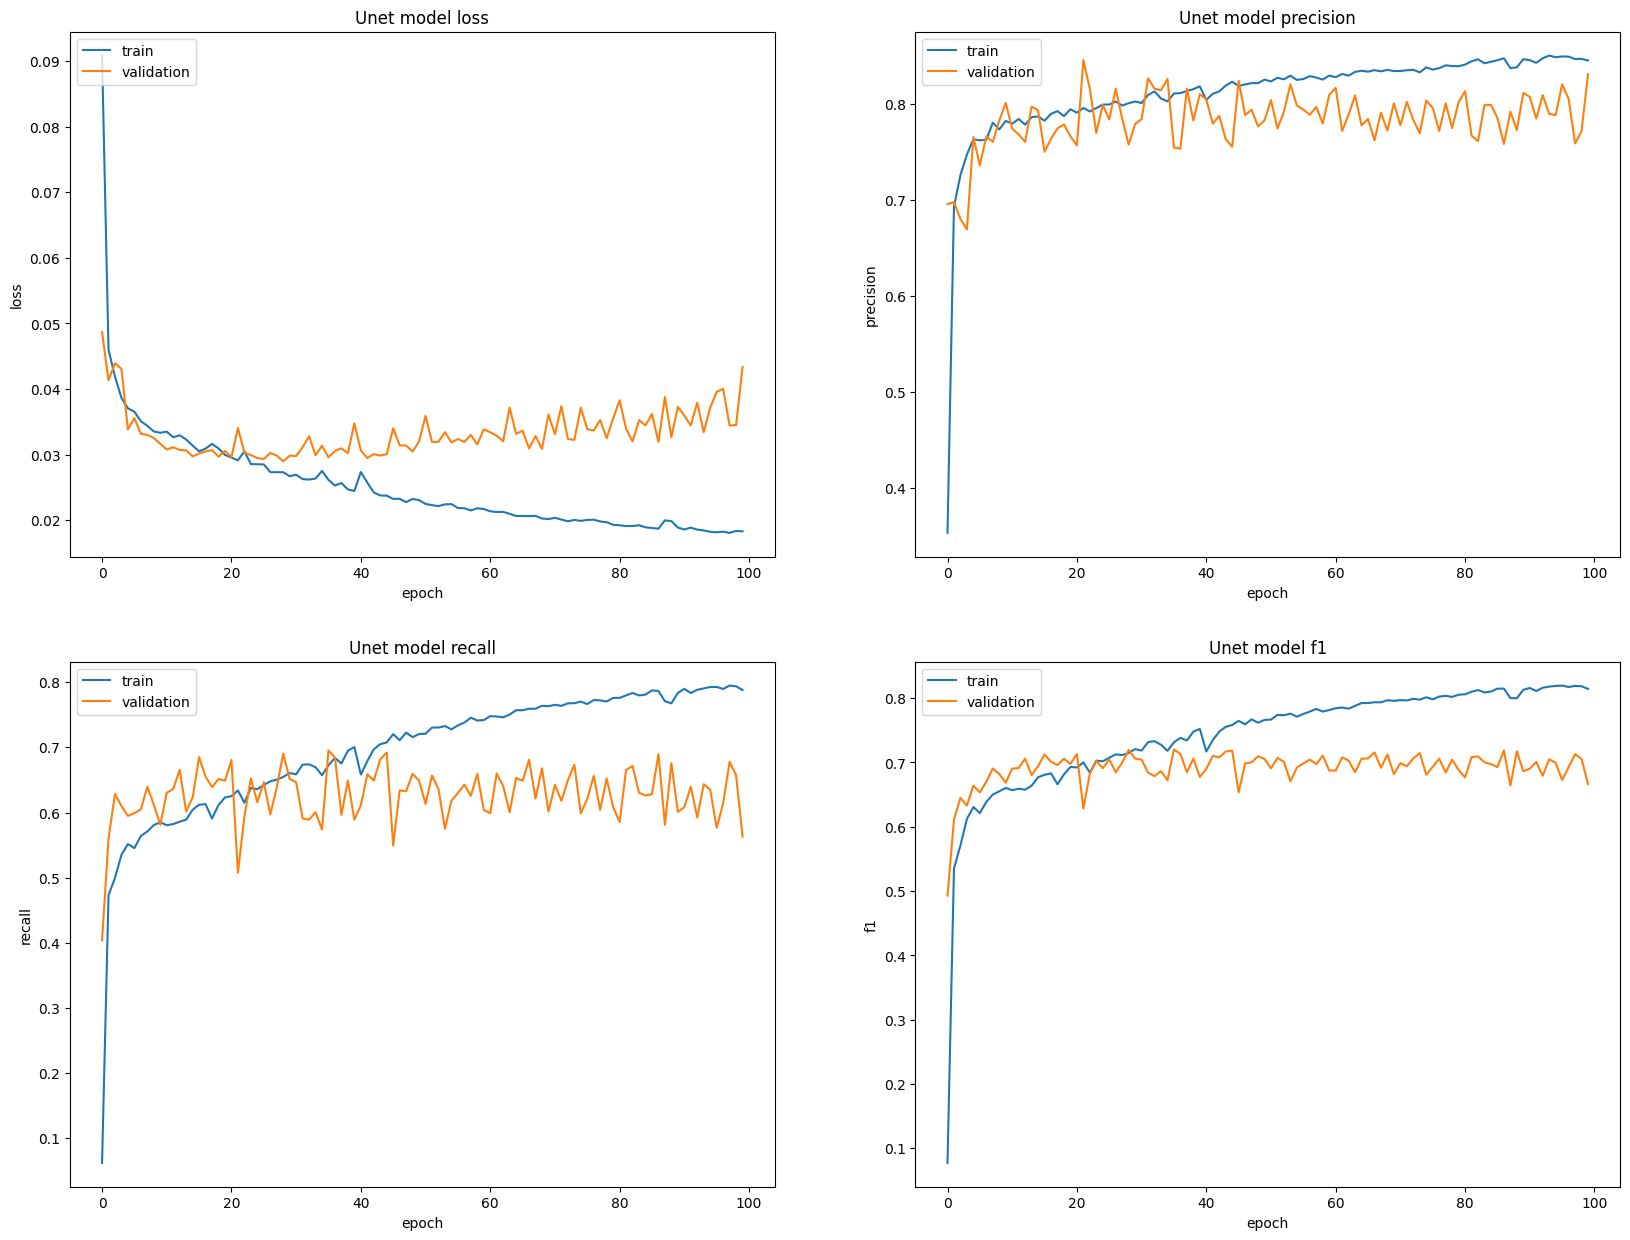

In [ ]:
fig,((ax11,ax12),(ax13,ax14)) = plt.subplots(2,2,figsize=(20,15))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.title.set_text('Unet model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('Unet model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('Unet model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('Unet model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')

In [ ]:
threshold = 0.5
pred_img = model.predict(x_valid)
pred_img = (pred_img > threshold).astype(np.uint8)

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step


Text(0.5, 1.0, 'Training Image')

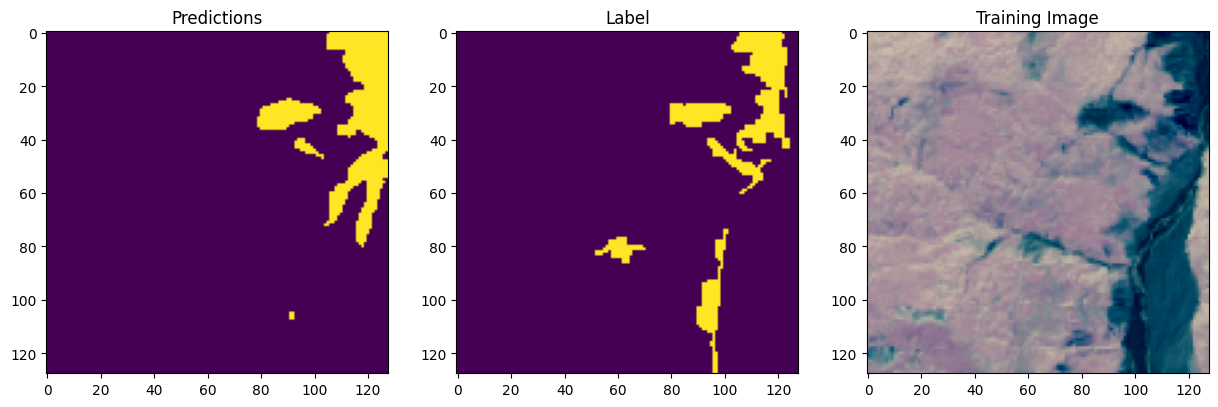

In [ ]:
img = 155
fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(y_valid[img, :, :, 0])
ax2.set_title("Label")
ax3.imshow(x_valid[img, :, :, 0:3])
ax3.set_title('Training Image')

Validation data

In [ ]:
import h5py
import numpy as np
import glob

validation_url = r'/content/drive/MyDrive/Colab Notebooks/data/ValidData/img/*.h5'
img_val = sorted(glob.glob(validation_url))

VAL_XX = np.zeros((245, 128, 128, 6))
mask_name = []

for i, img in enumerate(img_val):
    print(i, img)
    mask_name.append(img.split('/')[-1].replace('image','mask'))

    with h5py.File(img, 'r') as hdf:
        ls = list(hdf.keys())
        print(f"Keys in {img}: {ls}")

        # dynamically read the available dataset
        key = list(hdf.keys())[0]
        data = hdf[key][()].astype(np.float32)
        data[np.isnan(data)] = 0.000001

        # normalize
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # NDVI
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red))

        # final stacked array
        VAL_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  # RED
        VAL_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb  # GREEN
        VAL_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb  # BLUE
        VAL_XX[i, :, :, 3] = data_ndvi                   # NDVI
        VAL_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope     # SLOPE
        VAL_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation # ELEVATION


Prediction for validation data

In [ ]:
threshold = 0.5
pred_img = model.predict(VAL_XX)
pred_img = (pred_img > threshold).astype(np.uint8)
pred_img.shape

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


(245, 128, 128, 1)

Visualization of validation image

Text(0.5, 1.0, 'Training Image')

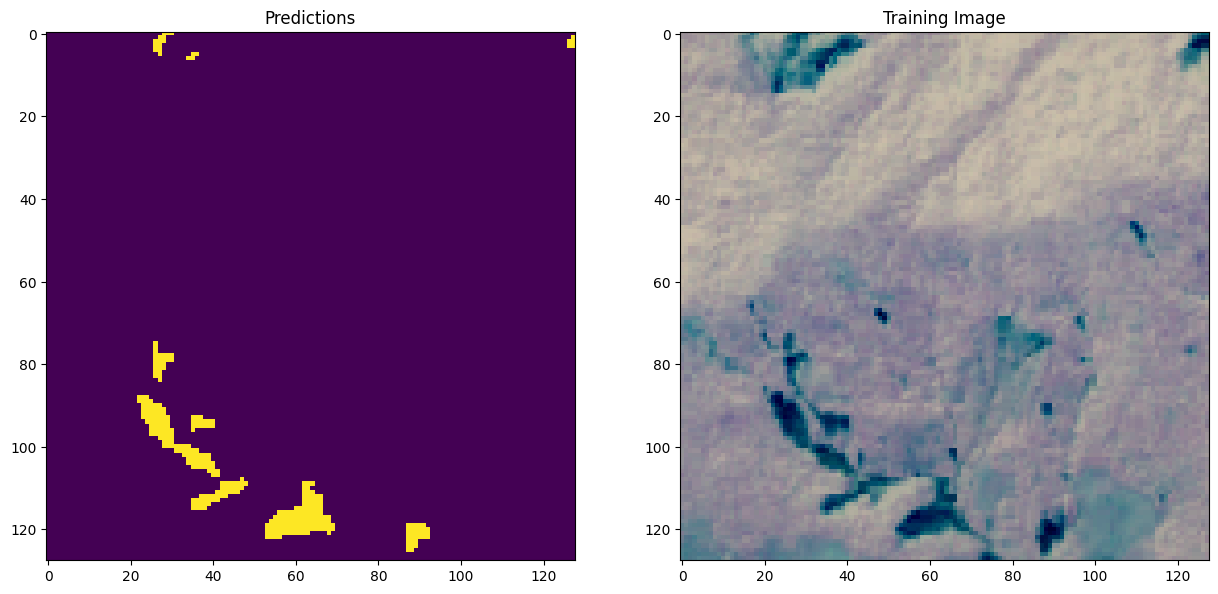

In [ ]:
img = 167
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(VAL_XX[img, :, :, 0:3])
ax2.set_title('Training Image')

Saved predicted masks

In [ ]:
import os
import h5py
import numpy as np
write_directory = '/content/drive/MyDrive/Colab Notebooks/data/ValidData/mask'
os.makedirs(write_directory, exist_ok=True)
mask_name = [f"mask_{i+1}.h5" for i in range(len(pred_img))]
for i, name in enumerate(mask_name):
# Create a new HDF5 file
h5f = h5py.File(os.path.join(write_directory, name), 'w')
# Extract the (128,128) mask from predicted output
pred_mask = pred_img[i, :, :, 0]
# Save dataset inside file
h5f.create_dataset('mask', data=pred_mask)
h5f.close()

print(f" Saved {len(mask_name)} predicted masks to: {write_directory}")


 Saved 245 predicted masks to: /content/drive/MyDrive/Colab Notebooks/data/ValidData/mask


Statistical Analysis

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    confusion_matrix,
    classification_report
)

%matplotlib inline
sns.set(style="whitegrid")


Descriptive Statistics


In [ ]:

def descriptive_statistics(data, name="Dataset"):
    print(f"\nDescriptive Statistics for {name}")
    print(pd.Series(data).describe())
    print(f"Skewness: {stats.skew(data):.4f}")
    print(f"Kurtosis: {stats.kurtosis(data):.4f}")
descriptive_statistics(y_true, "Ground Truth")
descriptive_statistics(y_pred, "Predictions")



Descriptive Statistics for Ground Truth
count    200.000000
mean       0.540000
std        0.499648
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
dtype: float64
Skewness: -0.1605
Kurtosis: -1.9742

Descriptive Statistics for Predictions
count    200.000000
mean       0.485000
std        0.501029
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
dtype: float64
Skewness: 0.0600
Kurtosis: -1.9964


Class distribution comparison

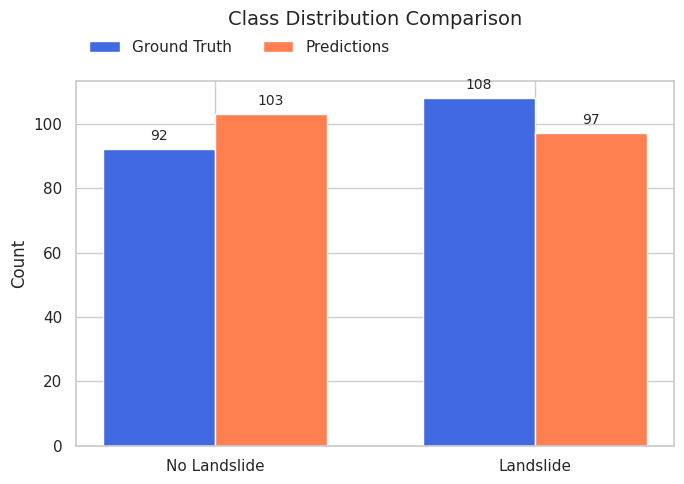

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual data)
labels = ['No Landslide', 'Landslide']
ground_truth_counts = [np.sum(y_true == 0), np.sum(y_true == 1)]
pred_counts = [np.sum(y_pred == 0), np.sum(y_pred == 1)]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(7,5))
bars1 = plt.bar(x - width/2, ground_truth_counts, width, label='Ground Truth', color='royalblue')
bars2 = plt.bar(x + width/2, pred_counts, width, label='Predictions', color='coral')

# Labels and title
plt.ylabel('Count', fontsize=12)
plt.title('Class Distribution Comparison', fontsize=14, pad=40)
plt.xticks(x, labels, fontsize=11)

# Legend on top-left, above the plot
plt.legend(
    loc='upper left',
    bbox_to_anchor=(0.0, 1.15),
    ncol=2,
    frameon=False,
    fontsize=11
)

# Add values above bars (optional, looks great in reports)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height + 2,
            f'{int(height)}',
            ha='center',
            va='bottom',
            fontsize=10
        )

plt.tight_layout()
plt.show()


Classification Metrics


Classification Report:
              precision    recall  f1-score   support

No Landslide       0.48      0.53      0.50        92
   Landslide       0.56      0.50      0.53       108

    accuracy                           0.52       200
   macro avg       0.52      0.52      0.51       200
weighted avg       0.52      0.52      0.52       200



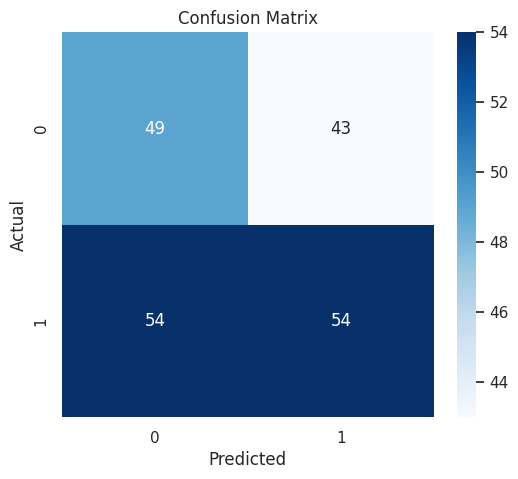

In [ ]:


def classification_analysis(y_true, y_pred, class_names=None):
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
classification_analysis(y_true, y_pred, class_names=["No Landslide", "Landslide"])


Correlation between features

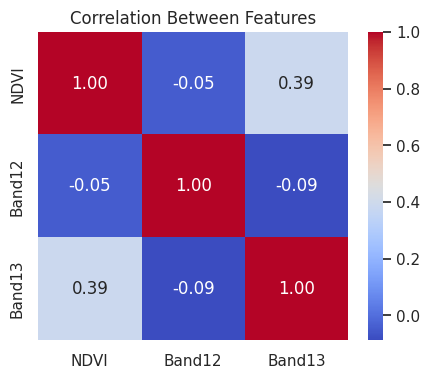

In [ ]:
import seaborn as sns
import pandas as pd

feature_matrix = np.stack([f_data[0, :, :, 0], f_data[0, :, :, 1], f_data[0, :, :, 2]], axis=-1)
df = pd.DataFrame(feature_matrix.reshape(-1, feature_matrix.shape[-1]), columns=['NDVI','Band12','Band13'])
plt.figure(figsize=(5,4))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Features')
plt.show()


NDVI (Normalized Difference Vegetation Index) → vegetation health indicator

Band12, Band13 → spectral bands (typically from Sentinel or MODIS satellite data, representing shortwave infrared or near-infrared reflectance)

What the Colors Mean

Red (Positive correlation, closer to +1) → features increase together.
Example: If NDVI increases, Band13 also tends to increase slightly (0.39).

Blue (Negative correlation, closer to -1) → when one increases, the other decreases.
Example: NDVI vs Band12 has a tiny negative link (-0.05).

Values near 0 → no significant linear relationship.

What This Means for Your Model

No multicollinearity issue — none of your features are highly correlated (>0.8), so all three contribute independent information.

NDVI adds unique vegetation-related context, Band12 and Band13 add soil/moisture-related context → together, they give a balanced spectral signature for landslide detection.

Error distribution

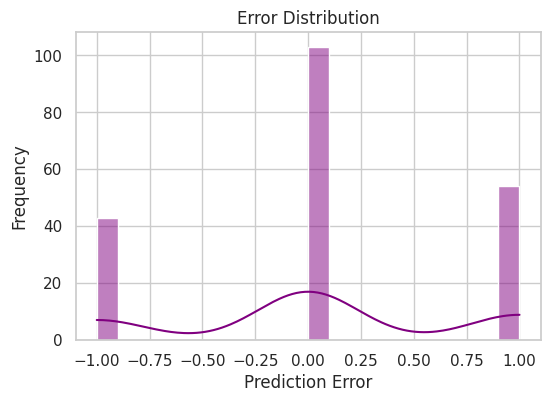

In [ ]:
errors = y_true - y_pred
plt.figure(figsize=(6,4))
sns.histplot(errors, kde=True, bins=20, color='purple')
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()


What This Distribution Means Statistically

Symmetry:
The left (-1) and right (+1) sides are roughly balanced — meaning your model makes both kinds of errors (false positives and false negatives) at similar rates.

Narrow Center Peak:
The high bar at zero means your model gets many predictions right.
However, the strong outer peaks show that when it fails, it fails completely (wrong class) — a common trait of binary classification models with discrete outputs (0 or 1).

KDE Curve (Purple line):
The smooth purple curve shows the probability density of errors. Its double dip (one near -1 and one near +1) confirms that errors cluster at those two extremes.

Spatial Part:

Convert into geotiff

In [ ]:
# h5_to_tif.py
import os, sys
import h5py
import numpy as np
import rasterio
from rasterio.transform import from_origin
from glob import glob

# ----- USER: set these to your folders -----
base_dir = r"/content/drive/MyDrive/Colab Notebooks/data"
train_img_dir = os.path.join(base_dir, "TrainData", "img")
train_mask_dir = os.path.join(base_dir, "TrainData", "mask")
valid_img_dir = os.path.join(base_dir, "ValidData", "img")
valid_mask_dir = os.path.join(base_dir, "ValidData", "mask")
out_dir = os.path.join(base_dir, "tiffs_output")
os.makedirs(out_dir, exist_ok=True)
# ------------------------------------------

def find_dataset_name(hf):
    # pick a dataset automatically if possible
    for k in hf.keys():
        # heuristics: prefer 'image', 'img', 'data', 'mask'
        if k.lower() in ('image','img','data','arr','array','tensor','images','masks','mask'):
            return k
    # fallback: first key
    keys = list(hf.keys())
    return keys[0] if keys else None

def save_image_tif(arr, outpath):
    # arr shape: (H,W) or (H,W,B) or (B,H,W) — try to handle common shapes
    if arr.ndim == 3 and arr.shape[0] <= 4 and arr.shape[0] < arr.shape[2]:
        # maybe (bands, H, W) -> transpose
        if arr.shape[0] < arr.shape[1] and arr.shape[1] == arr.shape[2]:
            # treat as (B,H,W) already OK
            pass
        else:
            # try convert (H,W,B) -> (B,H,W)
            arr = np.transpose(arr, (2,0,1))
    if arr.ndim == 2:
        count = 1
        arrw = arr[np.newaxis, ...]
    elif arr.ndim == 3:
        # assume (B,H,W)
        if arr.shape[0] < 10:  # likely bands are first axis
            arrw = arr
        else:
            # maybe (H,W,B)
            arrw = np.transpose(arr, (2,0,1))
    else:
        raise ValueError("Unsupported array shape: " + str(arr.shape))

    dtype = rasterio.float32
    # simple transform - we don't have georeference; set 1x1 pixel resolution origin at 0,0
    h = arrw.shape[1]; w = arrw.shape[2]
    transform = from_origin(0, h, 1, 1)

    profile = {
        'driver': 'GTiff',
        'height': h,
        'width': w,
        'count': arrw.shape[0],
        'dtype': dtype,
        'crs': None,
        'transform': transform,
        'compress': 'lzw'
    }
    with rasterio.open(outpath, 'w', **profile) as dst:
        for i in range(arrw.shape[0]):
            dst.write(arrw[i].astype('float32'), i+1)

def save_mask_tif(arr, outpath):
    # force single band uint8 (0/1 or class ids)
    if arr.ndim == 3:
        # if one-hot or (H,W,B) with B>1: convert to class indices by argmax
        if arr.shape[2] > 1:
            arr2 = np.argmax(arr, axis=2)
        else:
            arr2 = arr[:,:,0]
    elif arr.ndim == 2:
        arr2 = arr
    elif arr.ndim == 3 and arr.shape[0] <= 4: # (B,H,W)
        arr2 = np.argmax(arr, axis=0)
    else:
        raise ValueError("Unsupported mask shape: "+str(arr.shape))
    arr2 = np.nan_to_num(arr2).astype('uint8')
    h, w = arr2.shape
    transform = from_origin(0, h, 1, 1)
    profile = {
        'driver': 'GTiff',
        'height': h,
        'width': w,
        'count': 1,
        'dtype': 'uint8',
        'crs': None,
        'transform': transform,
        'compress': 'lzw'
    }
    with rasterio.open(outpath, 'w', **profile) as dst:
        dst.write(arr2, 1)

def process_folder(h5_pattern, out_subdir, kind='image'):
    files = sorted(glob(os.path.join(h5_pattern)))
    os.makedirs(out_subdir, exist_ok=True)
    print(f"Found {len(files)} files in {h5_pattern}")
    for f in files:
        try:
            with h5py.File(f, 'r') as hf:
                dname = find_dataset_name(hf)
                if dname is None:
                    print("No dataset found for", f, "keys:", list(hf.keys()))
                    continue
                arr = np.array(hf[dname])
                basename = os.path.splitext(os.path.basename(f))[0]
                outpath = os.path.join(out_subdir, f"{basename}.tif")
                if kind == 'image':
                    save_image_tif(arr, outpath)
                else:
                    save_mask_tif(arr, outpath)
                print("Saved", outpath, "shape", arr.shape)
        except Exception as e:
            print("ERR processing", f, e)

# Run for train and valid
process_folder(os.path.join(train_img_dir, "*.h5"), os.path.join(out_dir, "TrainData_img"), kind='image')
process_folder(os.path.join(train_mask_dir, "*.h5"), os.path.join(out_dir, "TrainData_mask"), kind='mask')
process_folder(os.path.join(valid_img_dir, "*.h5"), os.path.join(out_dir, "ValidData_img"), kind='image')
process_folder(os.path.join(valid_mask_dir, "*.h5"), os.path.join(out_dir, "ValidData_mask"), kind='mask')


Found 3799 files in /content/drive/MyDrive/Colab Notebooks/data/TrainData/img/*.h5
Saved /content/drive/MyDrive/Colab Notebooks/data/tiffs_output/TrainData_img/image_1.tif shape (128, 128, 14)
Saved /content/drive/MyDrive/Colab Notebooks/data/tiffs_output/TrainData_img/image_10.tif shape (128, 128, 14)
Saved /content/drive/MyDrive/Colab Notebooks/data/tiffs_output/TrainData_img/image_100.tif shape (128, 128, 14)
Saved /content/drive/MyDrive/Colab Notebooks/data/tiffs_output/TrainData_img/image_1000.tif shape (128, 128, 14)
Saved /content/drive/MyDrive/Colab Notebooks/data/tiffs_output/TrainData_img/image_1001.tif shape (128, 128, 14)
Saved /content/drive/MyDrive/Colab Notebooks/data/tiffs_output/TrainData_img/image_1002.tif shape (128, 128, 14)
Saved /content/drive/MyDrive/Colab Notebooks/data/tiffs_output/TrainData_img/image_1003.tif shape (128, 128, 14)
Saved /content/drive/MyDrive/Colab Notebooks/data/tiffs_output/TrainData_img/image_1004.tif shape (128, 128, 14)
Saved /content/driv

Saved /content/drive/MyDrive/Colab Notebooks/data/tiffs_output/TrainData_mask/mask_1389.tif shape (128, 128)
Saved /content/drive/MyDrive/Colab Notebooks/data/tiffs_output/TrainData_mask/mask_139.tif shape (128, 128)
Saved /content/drive/MyDrive/Colab Notebooks/data/tiffs_output/TrainData_mask/mask_1390.tif shape (128, 128)
Saved /content/drive/MyDrive/Colab Notebooks/data/tiffs_output/TrainData_mask/mask_1391.tif shape (128, 128)
Saved /content/drive/MyDrive/Colab Notebooks/data/tiffs_output/TrainData_mask/mask_1392.tif shape (128, 128)
Saved /content/drive/MyDrive/Colab Notebooks/data/tiffs_output/TrainData_mask/mask_1393.tif shape (128, 128)
Saved /content/drive/MyDrive/Colab Notebooks/data/tiffs_output/TrainData_mask/mask_1394.tif shape (128, 128)
Saved /content/drive/MyDrive/Colab Notebooks/data/tiffs_output/TrainData_mask/mask_1395.tif shape (128, 128)
Saved /content/drive/MyDrive/Colab Notebooks/data/tiffs_output/TrainData_mask/mask_1396.tif shape (128, 128)
Saved /content/drive